In [17]:
from typing import Annotated

from typing_extensions import TypedDict
from langgraph.graph import START, END, StateGraph  
from langgraph.graph.message import add_messages   #reducers

In [18]:
class State(TypedDict):
    messages:Annotated[list,add_messages] # updates the messhaes rather than overwriding them.
    
graph = StateGraph(State)

In [4]:
graph

In [6]:
import os
from dotenv import load_dotenv
load_dotenv()


True

In [18]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm = ChatGroq(model='llama-3.3-70b-versatile')

In [19]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000027BD388BB30>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000027BD3888F50>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [9]:
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [20]:
graph = StateGraph(State)

graph.add_node("llmchatbot", chatbot)
graph.add_edge(START, "llmchatbot")
graph.add_edge("llmchatbot",END)

graph=graph.compile()


In [22]:
response=graph.invoke({"messages":["hi"]})
response['messages'][-1].content

"It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [24]:
for event in graph.stream({"messages":"Hi how are you"}):
    for value in event.values():
        print(value["messages"][-1].content)

Hello. I'm just a language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help with any questions or topics you'd like to discuss. How about you? How's your day going?


LLM with tools

In [5]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [6]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm = ChatGroq(model='llama-3.3-70b-versatile')

In [8]:
from langchain_tavily import TavilySearch
tavily_tool = TavilySearch(max_results=5) 

In [9]:
tavily_tool.invoke("recent news on ML")

{'query': 'recent news on ML',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://aibusiness.com/ml',
   'title': 'ML recent news',
   'content': 'Explore the latest news and expert commentary on ML, brought to you by the editors of AI Business.',
   'score': 0.7570233,
   'raw_content': None},
  {'url': 'https://techxplore.com/machine-learning-ai-news/',
   'title': 'News on Artificial Intelligence and Machine Learning',
   'content': 'Machine learning & AI news· OpenAI and chipmaker AMD sign chip supply partnership for AI infrastructure · The reality of wholesale cheating with AI · Additive',
   'score': 0.7092009,
   'raw_content': None},
  {'url': 'https://www.wired.com/tag/machine-learning/',
   'title': 'Machine Learning | Latest News, Photos & Videos',
   'content': 'Chatbots Play With Your Emotions to Avoid Saying Goodbye· Anthropic Will Use Claude Chats for Training Data. · Meta Poaches OpenAI Scientist to Help Lead AI Lab.',
   'score'

In [10]:
def multiply(a:int,b:int)->int:
    '''
    Multiply a and b
    Args: 
       a in integer is the first number,
       b is the second number in integer.
    Returns: 
        int: result of multiplication of a and b
    '''
    return a*b

In [11]:
tools = [tavily_tool, multiply]

In [12]:
llm_with_tools = llm.bind_tools(tools)

In [14]:
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002CF40B73200>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002CF40C49E20>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description':

In [15]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


In [29]:
from typing import Annotated

from typing_extensions import TypedDict
from langgraph.graph import START, END, StateGraph  
from langgraph.graph.message import add_messages   #reducers

class State(TypedDict):
    messages:Annotated[list,add_messages] # updates the messhaes rather than overwriding them.
    
graph = StateGraph(State)

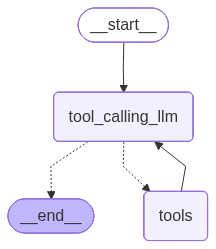

In [30]:
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

graph.add_node("tool_calling_llm", tool_calling_llm)
graph.add_node("tools", ToolNode(tools))

graph.add_edge(START, "tool_calling_llm")
graph.add_conditional_edges("tool_calling_llm",tools_condition)
graph.add_edge("tools", "tool_calling_llm")
graph.compile()

In [31]:
graph=graph.compile()

In [32]:
res=graph.invoke({"messages":"Give me latest news on AI, multiply 5 and 2"})

for res in res['messages']:
    res.pretty_print()

================================ Human Message =================================

Give me latest news on AI, multiply 5 and 2
================================== Ai Message ==================================
Tool Calls:
  tavily_search (rpvqvyhvd)
 Call ID: rpvqvyhvd
  Args:
    query: latest AI news
    search_depth: advanced
    topic: general
  multiply (58m5swnff)
 Call ID: 58m5swnff
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: tavily_search

{"query": "latest AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.artificialintelligence-news.com/", "title": "AI News | Latest AI News, Analysis & Events", "content": "Malaysia launches Ryt Bank, its first AI-powered bank · Finance AI. August 26, 2025 ; Google's Veo 3 AI video creation tools are now widely available · AI in", "score": 0.98516, "raw_content": null}, {"url": "https://hai.stanford.edu/ai-index/2025-ai-index-re

Memory including to the LLM

In [33]:
res = graph.invoke({"messages":"Hi this is MBYR"})

for res in res['messages']:
    res.pretty_print()

================================ Human Message =================================

Hi this is MBYR
================================== Ai Message ==================================

Hello MBYR, it's nice to meet you. Is there something I can help you with or would you like to chat?


In [34]:
res = graph.invoke({"messages":"What is my Name?"})

for res in res['messages']:
    res.pretty_print()

================================ Human Message =================================

What is my Name?
================================== Ai Message ==================================

I don't have any information about your name. This conversation just started, and I don't have any context or prior knowledge about you. If you'd like to share your name, I'd be happy to chat with you!


In [36]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver() # in memory checkpoint memory saver dictionary

In [39]:
from typing import Annotated

from typing_extensions import TypedDict
from langgraph.graph import START, END, StateGraph  
from langgraph.graph.message import add_messages   #reducers

class State(TypedDict):
    messages:Annotated[list,add_messages] # updates the messhaes rather than overwriding them.
    
graph = StateGraph(State)
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state['messages'])]}

graph.add_node("tool_calling_llm", tool_calling_llm)
graph.add_node("tools", ToolNode(tools))

graph.add_edge(START, "tool_calling_llm")
graph.add_conditional_edges("tool_calling_llm",tools_condition)
graph.add_edge("tools", "tool_calling_llm")
#graph.compile()

graph=graph.compile(checkpointer=memory)

In [46]:
config={"configurable":{"thread_id":"1"}}

In [47]:
res = graph.invoke({"messages":"My name is MBYR"}, config=config)

for res in res['messages']:
    res.pretty_print()

================================ Human Message =================================

My name is MBYR
================================== Ai Message ==================================

Hello MBYR, it's nice to meet you. Is there something I can help you with or would you like to chat?
================================ Human Message =================================

What is my Name?
================================== Ai Message ==================================

Your name is MBYR.
================================ Human Message =================================

My name is MBYR
================================== Ai Message ==================================
Tool Calls:
  tavily_search (6hhba7r9a)
 Call ID: 6hhba7r9a
  Args:
    query: MBYR
    search_depth: basic
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "MBYR", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.i

In [45]:
config_temp = {"configurable":{"thread_id":"12345"}}

In [48]:
res = graph.invoke({"messages":"What is my Name?"}, config=config_temp)

for res in res['messages']:
    res.pretty_print()

================================ Human Message =================================

What is my Name?
================================== Ai Message ==================================

I don't have any information about your name. This conversation just started, and I don't have the ability to access any personal information about you. If you'd like to share your name, I'd be happy to chat with you!
================================ Human Message =================================

What is my Name?
================================== Ai Message ==================================

I don't have enough information to determine your name. If you could provide more context or details, I'd be happy to try and help. Alternatively, if you're looking for information on how to find or retrieve your name, I can try to assist you with that as well.


In [49]:
res = graph.invoke({"messages":"What is my Name?"}, config=config)

for res in res['messages']:
    res.pretty_print()

================================ Human Message =================================

My name is MBYR
================================== Ai Message ==================================

Hello MBYR, it's nice to meet you. Is there something I can help you with or would you like to chat?
================================ Human Message =================================

What is my Name?
================================== Ai Message ==================================

Your name is MBYR.
================================ Human Message =================================

My name is MBYR
================================== Ai Message ==================================
Tool Calls:
  tavily_search (6hhba7r9a)
 Call ID: 6hhba7r9a
  Args:
    query: MBYR
    search_depth: basic
    topic: general
================================= Tool Message =================================
Name: tavily_search

{"query": "MBYR", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.i

Streaming

In [52]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [54]:
llm = ChatGroq(model='llama-3.3-70b-versatile')

def streaming_bot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}    

In [56]:
graph_builder = StateGraph(State)

graph_builder.add_node("streaming_bot", streaming_bot)

graph_builder.add_edge(START, "streaming_bot")
graph_builder.add_edge("streaming_bot", END)

graph_builder.compile(checkpointer=memory)

ValueError: Failed to reach https://mermaid.ink API while trying to render your graph. Status code: 400.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [63]:
graph=graph_builder.compile(checkpointer=memory)

In [64]:
config = {"configurable":{"thread_id":"1"}}

In [65]:
graph.invoke({'messages':"Hi this is MBYR, i love to play badminton"}, config)

{'messages': [HumanMessage(content='Hi this is MBYR, i love to play badminton', additional_kwargs={}, response_metadata={}, id='d6ba45fe-bf3d-49ef-a664-deab74d30f25'),
  AIMessage(content="Hello MBYR, it's great to hear that you enjoy playing badminton. Badminton is an exciting and fast-paced sport that requires a combination of speed, agility, and hand-eye coordination. What do you like most about playing badminton? Is it the thrill of smashing a winner, the strategy of outmaneuvering your opponent, or something else?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 78, 'prompt_tokens': 49, 'total_tokens': 127, 'completion_time': 0.145406288, 'prompt_time': 0.002754908, 'queue_time': 0.048175582, 'total_time': 0.148161196}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_9e1e8f8435', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--68049676-b268-42e4-be5a-cdb00ddad35a-0', usage_metadata={'input_tokens':

In [68]:
config = {"configurable":{"thread_id":"3"}}

for chunk in graph.stream({"messages":"Hi, this is MBYR"},config,stream_mode="updates"):
    print(chunk)
    
for chunk in graph.stream({"messages":"I love to play badminton"},config,stream_mode="updates"):
    print(chunk)

{'streaming_bot': {'messages': [AIMessage(content="Hello MBYR, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 42, 'total_tokens': 70, 'completion_time': 0.049731221, 'prompt_time': 0.002181169, 'queue_time': 0.048893647, 'total_time': 0.05191239}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_155ab82e98', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--a01fb328-0d80-4508-b818-583cc86b05aa-0', usage_metadata={'input_tokens': 42, 'output_tokens': 28, 'total_tokens': 70})]}}
{'streaming_bot': {'messages': [AIMessage(content="Badminton is a fantastic sport. It's a great way to stay active, improve your hand-eye coordination, and have fun. Do you play badminton competitively or just for recreation? And what's your favorite part about the game? Is it the thrill of smashing a shot, the strategy of 

In [69]:
config = {"configurable":{"thread_id":"4"}}

for chunk in graph.stream({"messages":"Hi, this is MBYR"},config,stream_mode="values"):
    print(chunk)
    
for chunk in graph.stream({"messages":"I love to play badminton"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi, this is MBYR', additional_kwargs={}, response_metadata={}, id='ecb70712-0cca-47fe-9537-ea83ccf390e5')]}
{'messages': [HumanMessage(content='Hi, this is MBYR', additional_kwargs={}, response_metadata={}, id='ecb70712-0cca-47fe-9537-ea83ccf390e5'), AIMessage(content="Hello MBYR, it's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 42, 'total_tokens': 70, 'completion_time': 0.049136265, 'prompt_time': 0.002019842, 'queue_time': 0.048704854, 'total_time': 0.051156107}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_155ab82e98', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--6f326a30-4830-4ebe-9ea6-7073a27721ee-0', usage_metadata={'input_tokens': 42, 'output_tokens': 28, 'total_tokens': 70})]}
{'messages': [HumanMessage(content='Hi, this is MBYR', additional_kwar